# Telco Churn Prediction Using Gradient Boosting

**Objective**: Predict customer churn using Gradient Boosting and identify high-risk customers. 
Steps include:
1. Data preprocessing (Label Encoding, One-Hot Encoding, type conversion)
2. Train-test-outsample split
3. Hyperparameter tuning using Randomized Search CV
4. Model evaluation using Accuracy, AUC, LogLoss, F1
5. ROC Curve visualization
6. Feature importance (both tree-based and SHAP)
7. High-risk segment identification and profiling

In [17]:
import pandas as pd

## 1. Load Dataset

In [18]:
df=pd.read_csv("D:\\DATA SCIENCE\\CHURN PROJ\\TELCO_CLEANED.csv")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Define Encoding Strategies
Label encoding for simple categorical features, One-Hot encoding for multi-category features

In [19]:
Encod_Label = ['gender', 'Partner', 'Dependents', 'PhoneService','Churn']
Num_label = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Encod_OneHot = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

## 3. Convert TotalCharges to numeric

In [20]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].dtype

dtype('float64')

## 4. Label Encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
le = LabelEncoder()
for col in Encod_Label:
    df[col] = le.fit_transform(df[col])

## 5. One-Hot Encoding

In [23]:
for col in Encod_OneHot:
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns=[col], axis=1, inplace=False)

In [24]:
print(df.dtypes)

gender                                     int32
SeniorCitizen                              int64
Partner                                    int32
Dependents                                 int32
tenure                                     int64
PhoneService                               int32
MonthlyCharges                           float64
TotalCharges                             float64
Churn                                      int32
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             bool
TechSupport_Yes     

## 6. Identify Numeric and Categorical Features

In [25]:
numeric_features = df.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'bool']).columns.tolist()

## 7. Fix column names & fill missing

In [26]:
df.rename(columns={'Churn_x':'Churn'}, inplace=True)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

## 8. PyCaret Setup (Optional)

In [27]:
from pycaret.classification import *

#Ensure target exists
assert 'Churn' in df.columns, "Column 'Churn' not found!"

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in df.columns if col not in numeric_features + ['Churn','customer ID']]

exp_clf = setup(
    data=df,
    target='Churn',
    session_id=123,
    numeric_features=numeric_features,
    categorical_features=categorical_features,
    fold_shuffle=True
)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 31)"
4,Transformed data shape,"(7043, 31)"
5,Transformed train set shape,"(4930, 31)"
6,Transformed test set shape,"(2113, 31)"
7,Numeric features,3
8,Categorical features,27
9,Preprocess,True


## 9. Compare Top Models by AUC

In [28]:
top3_auc = compare_models(n_select=3, sort='AUC')
print("Top 3 model berdasarkan AUC:")
for i, model in enumerate(top3_auc, 1):
    print(f"{i}. {model}") 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8022,0.8461,0.5260,0.6631,0.5845,0.4573,0.4639,0.2900
ada,Ada Boost Classifier,0.7992,0.8457,0.5291,0.6524,0.5821,0.4522,0.4578,0.2260
lr,Logistic Regression,0.8008,0.8449,0.5420,0.6526,0.5899,0.4602,0.4651,0.9980
catboost,CatBoost Classifier,0.7988,0.8397,0.5222,0.6531,0.5789,0.4491,0.4548,1.8580
qda,Quadratic Discriminant Analysis,0.7110,0.8368,0.8242,0.4750,0.6023,0.4004,0.4382,0.1730
ridge,Ridge Classifier,0.8014,0.8364,0.5222,0.6632,0.5818,0.4544,0.4615,0.1710
lda,Linear Discriminant Analysis,0.7959,0.8364,0.5497,0.6368,0.5879,0.4536,0.4572,0.1940
lightgbm,Light Gradient Boosting Machine,0.7933,0.8350,0.5321,0.6336,0.5769,0.4418,0.4457,0.3280
xgboost,Extreme Gradient Boosting,0.7901,0.8251,0.5298,0.6249,0.5716,0.4342,0.4379,0.3480
rf,Random Forest Classifier,0.7929,0.8237,0.4901,0.6451,0.5559,0.4244,0.4318,0.2840


Top 3 model berdasarkan AUC:
1. GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
2. AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=123)
3. LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2'

## 10. Train-Test-Outsample Split
Split data into train (70%), test (20%), outsample (10%) using stratification to preserve class ratio

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])
y = df['Churn']

X_train_full, X_outsample, y_train_full, y_outsample = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.222, random_state=42, stratify=y_train_full)
# 0.222 * 0.9 ≈ 20% total

print(f"Train: {len(X_train)}, Test: {len(X_test)}, Outsample: {len(X_outsample)}")

Train: 4930, Test: 1408, Outsample: 705


## 11. Define Gradient Boosting Model & Hyperparameter Space

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
gboost = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

## 12. Randomized Search CV

In [32]:
from sklearn.model_selection import RandomizedSearchCV

In [33]:
random_search = RandomizedSearchCV(
    estimator=gboost,
    param_distributions=param_dist,
    n_iter=30,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("\n=== Best Hyperparameters ===")
print(random_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits

=== Best Hyperparameters ===
{'subsample': 0.9, 'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.01}


## 13. Evaluate Model Performance

In [34]:
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, f1_score

In [35]:
def evaluate_model(model, X, y, label="Dataset"):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]
    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob)
    ll = log_loss(y, y_prob)
    f1 = f1_score(y, y_pred)
    print(f"\n[{label}] Accuracy: {acc:.3f} | AUC: {auc:.3f} | LogLoss: {ll:.3f} | F1: {f1:.3f}")
    return acc, auc, ll, f1, y_prob

train_metrics = evaluate_model(best_model, X_train, y_train, "Train")
test_metrics = evaluate_model(best_model, X_test, y_test, "Test")
outsample_metrics = evaluate_model(best_model, X_outsample, y_outsample, "Outsample")

y_train_prob = train_metrics[4]
y_test_prob = test_metrics[4]
y_out_prob = outsample_metrics[4]


[Train] Accuracy: 0.820 | AUC: 0.872 | LogLoss: 0.388 | F1: 0.613

[Test] Accuracy: 0.807 | AUC: 0.851 | LogLoss: 0.413 | F1: 0.589

[Outsample] Accuracy: 0.811 | AUC: 0.858 | LogLoss: 0.403 | F1: 0.578


## 14. Plot ROC Curve for Outsample

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

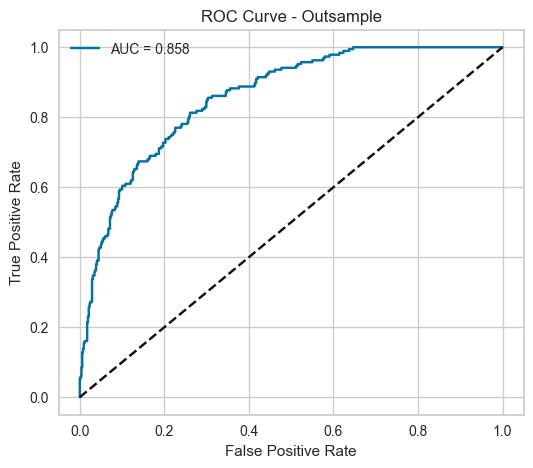

In [37]:
fpr, tpr, _ = roc_curve(y_outsample, y_out_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_outsample, y_out_prob):.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curve - Outsample')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## 15. Feature Importance (Gradient Boosting)

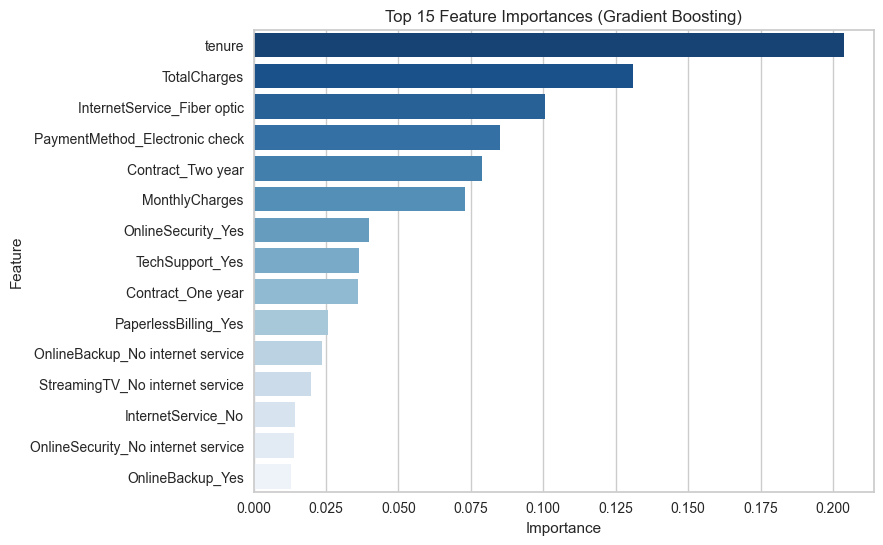

In [38]:
import seaborn as sns
import pandas as pd

importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=importances[:15], y=importances.index[:15], palette='Blues_r')
plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 16. Identify High-Risk Segment (Top 20% Probability)

In [39]:
def identify_risk_segment(probs, quantile=0.8):
    threshold = np.quantile(probs, quantile)
    return np.where(probs >= threshold, 'High Risk', 'Low Risk')

train_risk = identify_risk_segment(y_train_prob)
test_risk = identify_risk_segment(y_test_prob)
outsample_risk = identify_risk_segment(y_out_prob)

df_train = X_train.copy()
df_train['churn'] = y_train
df_train['risk_segment'] = train_risk

## 17. Profiling High Risk Segment

In [40]:
high_risk_profile = df_train[df_train['risk_segment']=='High Risk'].describe()
print(high_risk_profile)

           gender  SeniorCitizen     Partner  Dependents      tenure  \
count  986.000000     986.000000  986.000000  986.000000  986.000000   
mean     0.485801       0.306288    0.280933    0.110548    8.837728   
std      0.500052       0.461185    0.449683    0.313730   10.517476   
min      0.000000       0.000000    0.000000    0.000000    1.000000   
25%      0.000000       0.000000    0.000000    0.000000    1.000000   
50%      0.000000       0.000000    0.000000    0.000000    5.000000   
75%      1.000000       1.000000    1.000000    0.000000   11.750000   
max      1.000000       1.000000    1.000000    1.000000   58.000000   

       PhoneService  MonthlyCharges  TotalCharges       churn  
count    986.000000      986.000000    986.000000  986.000000  
mean       0.927992       78.592850    786.344371    0.712982  
std        0.258633       19.111852   1028.001913    0.452600  
min        0.000000       19.450000     19.450000    0.000000  
25%        1.000000       70.61

## 18. Visualize Feature Distribution by Risk Segment

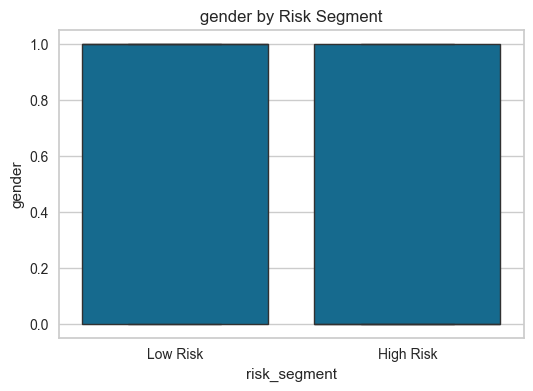

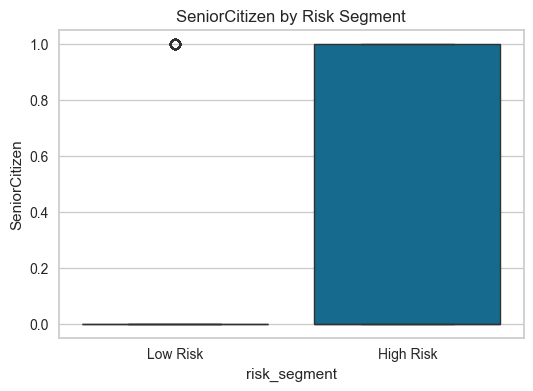

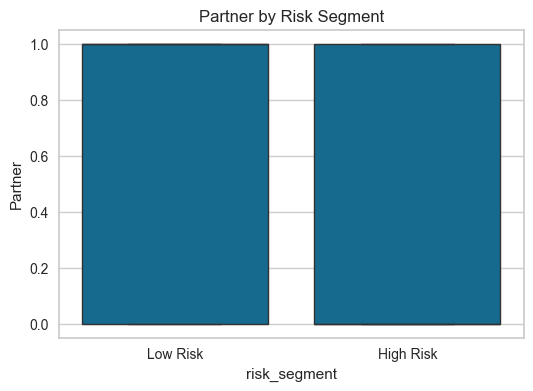

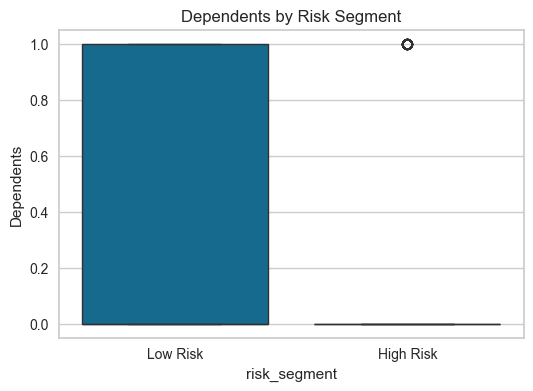

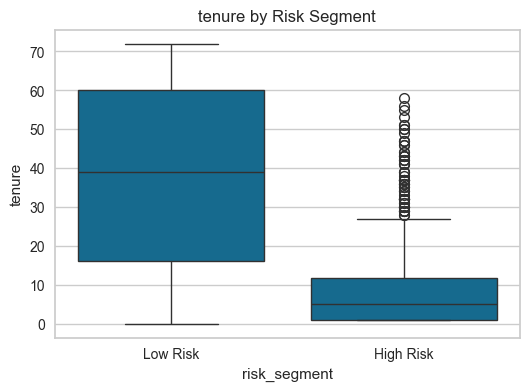

In [41]:
for col in X_train.columns[:5]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='risk_segment', y=col, data=df_train)
    plt.title(f'{col} by Risk Segment')
    plt.show()

## 19. SHAP Feature Importance

In [42]:
import shap

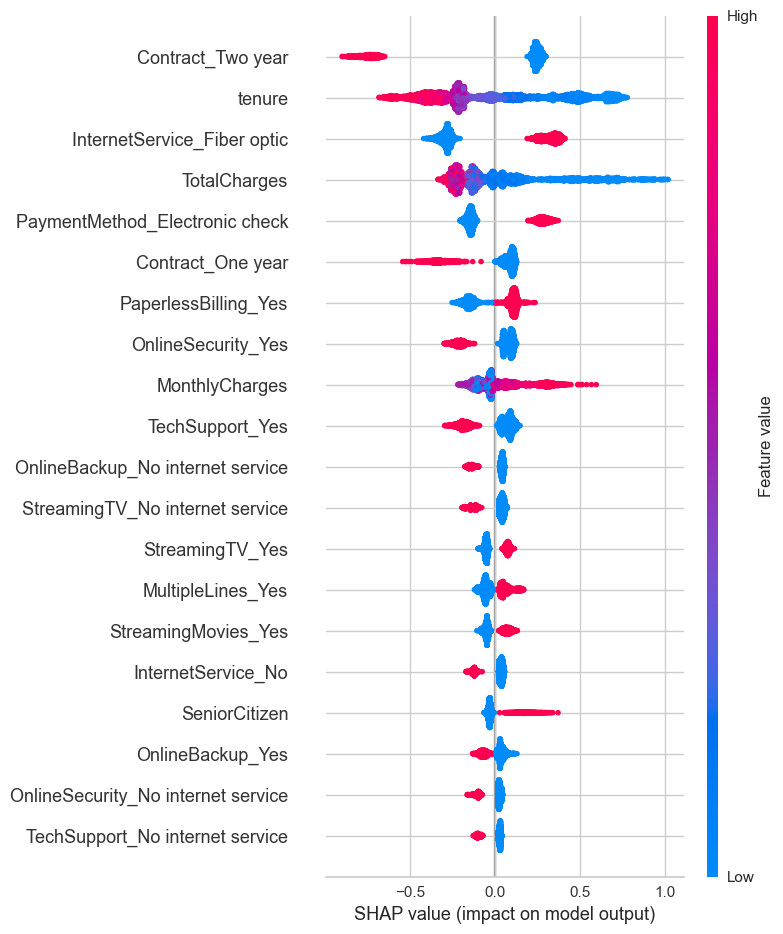

In [44]:

# Pastikan semua kolom numerik
X_train_num = pd.get_dummies(X_train, drop_first=True)

# Buat explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train_num)

# Plot
shap.summary_plot(shap_values, X_train_num)